<a href="https://colab.research.google.com/github/evysb/RL_in_stock_trading/blob/main/RL_in_stock_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

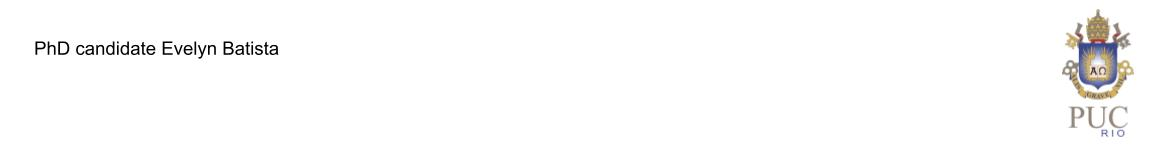

O material neste repositório são scripts do Professor Jones Granatyr modificador por mim.

## Instalar bibliotecas e montar drive do Google Drive

In [ ]:
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader
!pip install h5py==2.10.0 --force-reinstall
'''
CLICAR em restart runtime depois da instalação!!
'''

     |████████████████████████████████| 11.3 MB 7.1 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.3 which is incompatible.


     |████████████████████████████████| 109 kB 6.9 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0
     |████████████████████████████████| 2.9 MB 8.0 MB/s 
     |████████████████████████████████| 15.7 MB 53.2 MB/s 
  Attempting uninstall: six
    Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 r

'\nCLICAR em restart runtime depois da instalação!!\n'

### Tem algumas explicações de RL em negociação de ações aqui:

https://www.analyticsvidhya.com/blog/2021/01/bear-run-or-bull-run-can-reinforcement-learning-help-in-automated-trading/

Mas o código não é o mesmo!!

In [ ]:
!pip uninstall -y tensorflow
!pip install tensorflow-gpu==2.0.0-alpha0 #Usando versão específica do TF

Found existing installation: tensorflow 2.6.0
Uninstalling tensorflow-2.6.0:
  Successfully uninstalled tensorflow-2.6.0
     |████████████████████████████████| 332.5 MB 34 kB/s 
     |████████████████████████████████| 3.0 MB 39.8 MB/s 
     |████████████████████████████████| 411 kB 60.9 MB/s 
     |████████████████████████████████| 50 kB 6.5 MB/s 


In [ ]:
# Montar drive no google drive!
from google.colab import drive
drive.mount('/content/drive')

import os
workdir_path = '/content/drive/My Drive'
os.chdir(workdir_path)
os.mkdir("models_rl")
os.chdir('/content/drive/My Drive/models_rl')

Mounted at /content/drive


## Importar das bibliotecas

In [ ]:
import math
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas_datareader as data_reader # usado para nao ter que baixar o csv
from pandas.util.testing import assert_frame_equal

from tqdm import tqdm_notebook, tqdm
from collections import deque

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

In [ ]:
print("versão do TF ",tf.__version__)
print("versão do Pandas ",pd.__version__)
print("versão do pandas_datareader ", data_reader.__version__)

versão do TF  2.0.0-alpha0
versão do Pandas  1.3.3
versão do pandas_datareader  0.10.0


## Criação das funções que usaremos para treinar o modelo

In [ ]:
class Agent():

  def __init__(self, state_size, action_space = 3, continue_training=False): 
    self.state_size = state_size #depende do tamanho da janela (window_size)
    self.action_space = action_space #acoes: compra, venda, faz nada
    self.memory = deque(maxlen = 2000)
    self.gamma = 0.95 #0.9
    self.epsilon = 1.0
    self.epsilon_final = 0.01
    self.epsilon_decay = 0.995
    self.model = self.get_model()
  
  '''
    Política
  '''
  def trade(self, state): #função que vai fazer a negociação, vai retornar as ações
    if random.random() <= self.epsilon:
      return random.randrange(self.action_space) # no inicio será aleatório
    
    actions = self.model.predict(state) #depois usará as predição da rede
    return np.argmax(actions[0])
  
  '''
    Cria a rede e compila - pode mudar conforme o necessário
  '''
  def get_model(self):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units = 16, activation = "relu", input_dim = self.state_size))
    model.add(tf.keras.layers.Dense(units = 32, activation = "relu"))
    model.add(tf.keras.layers.Dense(units = 64, activation = "relu"))
    model.add(tf.keras.layers.Dense(units = self.action_space, activation = "linear"))
    model.compile(loss = "mse", optimizer = tf.keras.optimizers.Adam(lr = 0.001))
    return model
  
  '''
    Treinamento da rede
  '''
  def train_on_batch(self, batch_size):
    batch = []
    for i in range(len(self.memory) - batch_size + 1, len(self.memory)): #pega as ultimas transações da memória
      batch.append(self.memory[i])
      
    for state, action, reward, next_state, done in batch:
      if not done:
        #Faz previsoes para o próximo estado
        #self.model.predict(next_state)[0] -> valores de Q no estado next_state
        #np.amax(self.model.predict(next_state)[0]) #busca ql maior valor de Q(s,a), ou seja, ql maior R
        reward = reward + self.gamma * np.amax(self.model.predict(next_state)[0]) #Eq Bellman
        
      target = self.model.predict(state)
      target[0][action] = reward #associa a ação que levou a ter a reward calculada
      
      self.model.fit(state, target, epochs=3, verbose=0) #TODO mudar ep
      
    if self.epsilon > self.epsilon_final:
      self.epsilon *= self.epsilon_decay
      

## Análise e pré-processamento da base de dados

#### Sigmoid

usado para normalizar entre 0 e 1

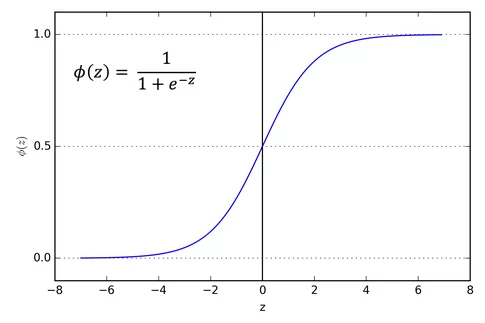

In [ ]:
def sigmoid(z):
  return 1 / (1 + math.exp(-z))

In [ ]:
sigmoid(0.5)

0.6224593312018546

#### Formatação de preços

verifica se está tendo lucro ou não e formata (deixa bonitinho)

In [ ]:
def stocks_price_format(n):
  if n < 0:
    return "- $ {0:2f}".format(abs(n))
  else:
    return "$ {0:2f}".format(abs(n))

In [ ]:
stocks_price_format(100)

'$ 100.000000'

#### Análise e criação da função de carregar a base de dados

In [ ]:
dataset_total = data_reader.DataReader("AAPL", data_source = "yahoo") #ações da Apple

In [ ]:
#pega só 1000 dados para treino e teste
dataset = dataset_total[:1000]
dataset_test = dataset_total[1000:]

In [ ]:
'''
Quais dados temos:
Date - data
High - maior preço foi vendido no dia
Low - menor preço foi vendido no dia
Open - valor de abertura, qto que a ação valia no inicio do dia
Close	- valor de fechamento,  qto que a ação foi vendida no final do dia
Volume - volume de ações que foram transacionadas nesse dia
Adj Close - qto que valeria a ação considerando dividendos e outros fatores

****AGORA so vamos utilizar apenas o close
'''
dataset.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-10-07,28.639999,28.377501,28.577499,28.514999,97433600.0,26.742519
2016-10-10,29.187500,28.680000,28.754999,29.012501,144944000.0,27.209097
2016-10-11,29.672501,29.049999,29.424999,29.075001,256164000.0,27.267715
2016-10-12,29.495001,29.187500,29.337500,29.334999,150347200.0,27.511547
2016-10-13,29.360001,28.930000,29.197500,29.245001,140769600.0,27.427147


In [ ]:
str(dataset.index[0]).split()[0]

'2016-10-07'

In [ ]:
dataset.index[-1]

Timestamp('2020-09-28 00:00:00')

In [ ]:
dataset['Close']

Date
2016-10-07     28.514999
2016-10-10     29.012501
2016-10-11     29.075001
2016-10-12     29.334999
2016-10-13     29.245001
                 ...    
2020-09-22    111.809998
2020-09-23    107.120003
2020-09-24    108.220001
2020-09-25    112.279999
2020-09-28    114.959999
Name: Close, Length: 1000, dtype: float64

In [ ]:
def dataset_loader(dataset):
  #TODO pegar outros além do Close
  close = dataset['Close']
  return close

### Criador de estados - com janelamento

In [ ]:
0 - 5 + 1

-4

In [ ]:
20 - 5 + 1

16

In [ ]:
dataset[16:21]

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-10-31,28.557501,28.299999,28.412500,28.385000,105677600.0,26.620600
2016-11-01,28.442499,27.632500,28.365000,27.872499,175303200.0,26.139957
2016-11-02,28.087500,27.807501,27.850000,27.897499,113326800.0,26.163404
2016-11-03,27.865000,27.387501,27.745001,27.457500,107730400.0,25.882967
2016-11-04,27.562500,27.027500,27.132500,27.209999,123348000.0,25.649656


In [ ]:
#vai fazer D - D' para capturar a tendencia, se sobe ou não o número
#se identifica que a tendencia é subir o preço, o agente nao vai comprar

'''
        state                       target
[30.2 , 32.4 , [...], 40.7 , 53.5] [46.1]
subtraindo...
32.4 - 30.2 = 2.2
32.4 - ... = ...
53.5 - 40.7 = 12.8
'''

def state_creator(data, timestep, window_size): 
  starting_id = timestep - window_size + 1 # da onde vai começar a pegar os dados na base
  
  if starting_id >= 0:
    windowed_data = data[starting_id:timestep + 1]
  else:
    windowed_data = - starting_id * [data[0]] + list(data[0:timestep + 1]) #vai repetir os valores de starting_id for negativo
    
  state = []
  for i in range(window_size - 1):
    state.append(sigmoid(windowed_data[i + 1] - windowed_data[i])) #normaliza dos dados e os subtrai
    
  return np.array([state]), windowed_data

### Loading da base de dados

In [ ]:
data = dataset_loader(dataset) #LEMBRANDO: so tem close!

In [ ]:
data_test = dataset_loader(dataset_test) #so tem close!

In [ ]:
s, w = state_creator(data, 0, 5)

In [ ]:
s

array([[0.5, 0.5, 0.5, 0.5]])

In [ ]:
w

[28.514999389648438,
 28.514999389648438,
 28.514999389648438,
 28.514999389648438,
 28.514999389648438]

## Fase de Treinamento:

### Configuração dos hyper parâmetros

In [ ]:
window_size = 10 #com 10 numeros, quer prever se compra ou nao
episodes = 1 #AUMENTAR
batch_size = 32
data_samples = len(data) - 1
data_samples_test = len(data_test) - 1

### Modelo

In [ ]:
agent = Agent(window_size)

In [ ]:
agent.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                176       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 195       
Total params: 3,027
Trainable params: 3,027
Non-trainable params: 0
_________________________________________________________________


### Treinamento:

In [ ]:
for episode in range(1, episodes + 1):
  print("Episode: {}/{}".format(episode, episodes))
  state = state_creator(data, 0, window_size + 1)
  total_profit = 0
  agent.inventory = []
  for t in tqdm(range(data_samples)):
    action = agent.trade(state)
    next_state = state_creator(data, t + 1, window_size + 1)
    reward = 0
    
    if action == 1: # Comprando uma ação
      agent.inventory.append(data[t])
      print("Agent bought: ", stocks_price_format(data[t]))
    elif action == 2 and len(agent.inventory) > 0: # Vendendo uma ação, dado que so posso vender se ja comprei algo!
      buy_price = agent.inventory.pop(0) #remove 1 item da pilha e pega o preço que foi pago
      
      reward = max(data[t] - buy_price, 0) #valor atual da ação - valor pago #MAX pra não deixar recompensa negativa! (Pode ser modificado!)
      total_profit += data[t] - buy_price
      print("Agent sold: ", stocks_price_format(data[t]), " Profit: " + stocks_price_format(data[t] - buy_price))
      
    if t == data_samples - 1:
      done = True
    else:
      done = False
      
    agent.memory.append((state, action, reward, next_state, done))
    
    state = next_state
    
    if done:
      print("######## DONE ########")
      print("-- [INFO] Total profit: ", total_profit)
      
    if len(agent.memory) > batch_size:
      agent.train_on_batch(batch_size)
     
  #if episode % 10 == 0:
  agent.model.save("model_{}.h5".format(episode)) #Salvando arquitetura e pesos!
    

Episode: 1/1


  0%|          | 0/999 [00:00<?, ?it/s]

Agent bought:  $ 29.334999
Agent bought:  $ 29.245001
Agent sold:  $ 29.407499  Profit: $ 0.072500
Agent sold:  $ 29.387501  Profit: $ 0.142500
Agent bought:  $ 28.430000
Agent bought:  $ 27.872499
Agent bought:  $ 27.897499
Agent bought:  $ 27.209999
Agent sold:  $ 27.764999  Profit: - $ 0.665001
Agent sold:  $ 27.719999  Profit: - $ 0.152500
Agent bought:  $ 26.947500
Agent bought:  $ 27.107500
Agent bought:  $ 26.777500
Agent sold:  $ 27.497499  Profit: - $ 0.400000
Agent bought:  $ 27.487499
Agent bought:  $ 27.514999
Agent sold:  $ 27.932501  Profit: $ 0.722502


  3%|▎         | 33/999 [00:01<00:50, 19.07it/s]

Agent bought:  $ 27.807501


  4%|▎         | 35/999 [00:02<01:17, 12.46it/s]

Agent sold:  $ 27.892500  Profit: $ 0.945000


  4%|▎         | 36/999 [00:02<01:34, 10.23it/s]

Agent bought:  $ 27.865000


  4%|▍         | 38/999 [00:03<02:21,  6.78it/s]

Agent sold:  $ 27.372499  Profit: $ 0.264999


  4%|▍         | 40/999 [00:04<01:53,  8.48it/s]


Agent bought:  $ 27.277500


KeyboardInterrupt: ignored

# Inferência

In [ ]:
model = tf.keras.models.load_model("model_1.h5")

In [ ]:
for t in tqdm(range(data_samples_test)):
  state = state_creator(data_test, t + 1, window_size + 1)
  print(state)
  action = model.predict(state)
  result = np.argmax(action[0])
  print("result ", result)
  
  if result == 1:
    print("-- [INFO] bought!")
  elif result == 2:
    print("-- [INFO] sold!")
  else:
    print("-- [INFO] do nothing!")
  print('\n')
  print('-----------------------------')
  print('\n')

  6%|▌         | 15/257 [00:00<00:01, 149.40it/s]

(array([[0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.5       , 0.5       , 0.5       , 0.5       , 0.84812899]]), [114.08999633789062, 114.08999633789062, 114.08999633789062, 114.08999633789062, 114.08999633789062, 114.08999633789062, 114.08999633789062, 114.08999633789062, 114.08999633789062, 114.08999633789062, 115.80999755859375])
result  1
-- [INFO] bought!


-----------------------------


(array([[0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.5       , 0.5       , 0.5       , 0.84812899, 0.72710888]]), [114.08999633789062, 114.08999633789062, 114.08999633789062, 114.08999633789062, 114.08999633789062, 114.08999633789062, 114.08999633789062, 114.08999633789062, 114.08999633789062, 115.80999755859375, 116.79000091552734])
result  1
-- [INFO] bought!


-----------------------------


(array([[0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.5       , 0.5       , 0.84812899, 0.72710888, 0.02253255]]), [114.0899963

 25%|██▍       | 63/257 [00:00<00:00, 216.32it/s]

result  1
-- [INFO] bought!


-----------------------------


(array([[0.41338279, 0.97125141, 0.43045408, 0.51249816, 0.73885018,
        0.28699909, 0.2042402 , 0.64794094, 0.2141645 , 0.02959817]]), Date
2020-11-09    116.320000
2020-11-10    115.970001
2020-11-11    119.489998
2020-11-12    119.209999
2020-11-13    119.260002
2020-11-16    120.300003
2020-11-17    119.389999
2020-11-18    118.029999
2020-11-19    118.639999
2020-11-20    117.339996
2020-11-23    113.849998
Name: Close, dtype: float64)
result  2
-- [INFO] sold!


-----------------------------


(array([[0.97125141, 0.43045408, 0.51249816, 0.73885018, 0.28699909,
        0.2042402 , 0.64794094, 0.2141645 , 0.02959817, 0.78918166]]), Date
2020-11-10    115.970001
2020-11-11    119.489998
2020-11-12    119.209999
2020-11-13    119.260002
2020-11-16    120.300003
2020-11-17    119.389999
2020-11-18    118.029999
2020-11-19    118.639999
2020-11-20    117.339996
2020-11-23    113.849998
2020-11-24    115.169998
Name: Clo

 42%|████▏     | 109/257 [00:00<00:00, 221.65it/s]

 1
-- [INFO] bought!


-----------------------------


(array([[0.98522592, 0.99215495, 0.90025061, 0.97916347, 0.559715  ,
        0.24973875, 0.00689526, 0.00588182, 0.8984384 , 0.70056842]]), Date
2021-01-19    127.830002
2021-01-20    132.029999
2021-01-21    136.869995
2021-01-22    139.070007
2021-01-25    142.919998
2021-01-26    143.160004
2021-01-27    142.059998
2021-01-28    137.089996
2021-01-29    131.960007
2021-02-01    134.139999
2021-02-02    134.990005
Name: Close, dtype: float64)
result  2
-- [INFO] sold!


-----------------------------


(array([[0.99215495, 0.90025061, 0.97916347, 0.559715  , 0.24973875,
        0.00689526, 0.00588182, 0.8984384 , 0.70056842, 0.25922451]]), Date
2021-01-20    132.029999
2021-01-21    136.869995
2021-01-22    139.070007
2021-01-25    142.919998
2021-01-26    143.160004
2021-01-27    142.059998
2021-01-28    137.089996
2021-01-29    131.960007
2021-02-01    134.139999
2021-02-02    134.990005
2021-02-03    133.940002
Name: Close, dty

 60%|██████    | 155/257 [00:00<00:00, 214.15it/s]

result  1
-- [INFO] bought!


-----------------------------


(array([[0.65021917, 0.54487897, 0.18392205, 0.90465054, 0.70056682,
        0.94784651, 0.57688467, 0.84422448, 0.9212896 , 0.93339193]]), Date
2021-03-25    120.589996
2021-03-26    121.209999
2021-03-29    121.389999
2021-03-30    119.900002
2021-03-31    122.150002
2021-04-01    123.000000
2021-04-05    125.900002
2021-04-06    126.209999
2021-04-07    127.900002
2021-04-08    130.360001
2021-04-09    133.000000
Name: Close, dtype: float64)
result  1
-- [INFO] bought!


-----------------------------


(array([[0.54487897, 0.18392205, 0.90465054, 0.70056682, 0.94784651,
        0.57688467, 0.84422448, 0.9212896 , 0.93339193, 0.14679103]]), Date
2021-03-26    121.209999
2021-03-29    121.389999
2021-03-30    119.900002
2021-03-31    122.150002
2021-04-01    123.000000
2021-04-05    125.900002
2021-04-06    126.209999
2021-04-07    127.900002
2021-04-08    130.360001
2021-04-09    133.000000
2021-04-12    131.240005
Name: C

 77%|███████▋  | 199/257 [00:00<00:00, 211.97it/s]

 2
-- [INFO] sold!


-----------------------------


(array([[0.17221644, 0.33849725, 0.41824018, 0.68567985, 0.17946201,
        0.91293411, 0.50250051, 0.69846444, 0.59628255, 0.26502805]]), Date
2021-05-26    126.849998
2021-05-27    125.279999
2021-05-28    124.610001
2021-06-01    124.279999
2021-06-02    125.059998
2021-06-03    123.540001
2021-06-04    125.889999
2021-06-07    125.900002
2021-06-08    126.739998
2021-06-09    127.129997
2021-06-10    126.110001
Name: Close, dtype: float64)
result  2
-- [INFO] sold!


-----------------------------


(array([[0.33849725, 0.41824018, 0.68567985, 0.17946201, 0.91293411,
        0.50250051, 0.69846444, 0.59628255, 0.26502805, 0.77556364]]), Date
2021-05-27    125.279999
2021-05-28    124.610001
2021-06-01    124.279999
2021-06-02    125.059998
2021-06-03    123.540001
2021-06-04    125.889999
2021-06-07    125.900002
2021-06-08    126.739998
2021-06-09    127.129997
2021-06-10    126.110001
2021-06-11    127.349998
Name: Close, dtype

100%|██████████| 257/257 [00:01<00:00, 213.23it/s]

result  1
-- [INFO] bought!


-----------------------------


(array([[0.39891124, 0.52747246, 0.28495827, 0.48750184, 0.37989587,
        0.56463494, 0.95391112, 0.55230957, 0.88287987, 0.2829262 ]]), Date
2021-08-03    147.360001
2021-08-04    146.949997
2021-08-05    147.059998
2021-08-06    146.139999
2021-08-09    146.089996
2021-08-10    145.600006
2021-08-11    145.860001
2021-08-12    148.889999
2021-08-13    149.100006
2021-08-16    151.119995
2021-08-17    150.190002
Name: Close, dtype: float64)
result  2
-- [INFO] sold!


-----------------------------


(array([[0.52747246, 0.28495827, 0.48750184, 0.37989587, 0.56463494,
        0.95391112, 0.55230957, 0.88287987, 0.2829262 , 0.02124828]]), Date
2021-08-04    146.949997
2021-08-05    147.059998
2021-08-06    146.139999
2021-08-09    146.089996
2021-08-10    145.600006
2021-08-11    145.860001
2021-08-12    148.889999
2021-08-13    149.100006
2021-08-16    151.119995
2021-08-17    150.190002
2021-08-18    146.360001
Name: Clo